<a href="https://colab.research.google.com/github/Furatus/4MLUP_Anthem/blob/main/4MLUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>Apprentissage non supervisé - Étude des hymnes nationaux</u>

Ce document est un rapport d'étude des hymnes nationaux dans un contexte d'apprentissage non-supervisé. Il comporte plusieurs parties indispensables à l'analyse des différents hymnes.

On retrouvera (sommaire) :

- Une analyse exploratoire, bien que rapide car notre dataset ne comporte pas beaucoup de variables, on décrira rapidement les données qui nous sont fournies
- Un Patitionnement par K-means
- Un Partitionnement Hiérarchique

---

## Généralités du document | Définition des variables globales

On commence par importer toutes les librairies dont nous aurons besoin lors de cette étude:

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords

*(Le fichier csv est disponible sur kaggle, ou directement sur ce repository github)*

In [7]:
csvfileurl = "https://raw.githubusercontent.com/Furatus/4MLUP_Anthem/refs/heads/main/anthems.csv"

df_anthem = pd.read_csv(csvfileurl)

---

## Analyse Exploratoire

Notre analyse débute par un description générale du dataset :

In [13]:
df_anthem.info()
df_anthem.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.6+ KB


,Country,Alpha-2,Alpha-3,Continent,Anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"We knew thee of old, O, divinely restored, By ..."
freq,1,2,1,56,2


On observe qu'il manque uniquement 1 seule valeur parmis tout le dataset, vérifions quel est le pays auquel la valeur manque

In [14]:
df_anthem[df_anthem['Alpha-2'].isna()]

,Country,Alpha-2,Alpha-3,Continent,Anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


La Namibie n'a pas de code alpha-2 dans ce dataset (Officillement, c'est "NA").

> Mais ce n'est pas grave, car les variables Alpha-2 et Alpha-3 ne nous intéresseront pas dans notre apprentissage ni dans notre analyse, nous allons donc les supprimer pour ne pas parasiter le clustering


In [15]:
df_anthem = df_anthem.drop(columns=['Alpha-2','Alpha-3'])

([<matplotlib.patches.Wedge at 0x7f510be82b90>,
 [Text(0.6611892807271458, 0.8791067825079726, ''),
  Text(-0.9307049301123573, 0.5863346596139036, ''),
  Text(-0.6898936616108229, -0.8567652745467755, ''),
  Text(0.474930303518996, -0.992190106178929, ''),
  Text(0.9495821761554283, -0.5552420109537113, ''),
  Text(1.0849974441190637, -0.18105398712842366, '')])

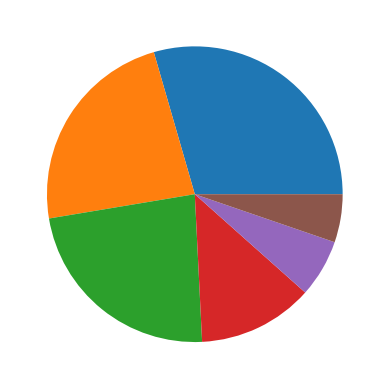

In [19]:
plt.pie(df_anthem['Continent'].value_counts())